In [1]:
import os
import glob
import time
import random
 
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


## STEP 1. 데이터셋 구성하기

분류 문제에서와 달리, 각 이미지가 어떤 카테고리인지 나타내주는 라벨이 필요 없습니다. 그렇기 때문에 코드에서 _ (언더스코어)로 해당 데이터들은 무시하도록 하겠습니다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, train_y), (test_x, test_y) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def tolabel(i: int):
    name = labels[i]
    return name

In [5]:
tolabel(0)

'airplane'

In [6]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* reshape(28, 28), cmap='gray' 안해주고 imshow해주는 이유? 
    - 위에서 shape을 확인했을 때 이미 cifar10의 데이터 구조는 딥러닝에 적합하게 개수, width, height, channels로 구성되어 있습니다. 그래서 굳이 RGB 채널의 데이터를 gray로 또는 이미지 사이즈로 리사이즈해줄 필요가 없습니다. mnist와의 데이터 구조상의 차이가 있습니다. 

In [7]:
i = random.randint(1,100)
print(i)
print(int(train_y[i]))

6
2


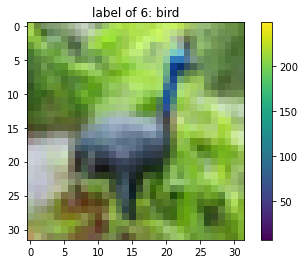

In [8]:
plt.imshow(train_x[i])
plt.title(f'label of {i}: {tolabel(int(train_y[i]))}')
plt.colorbar()
plt.show()

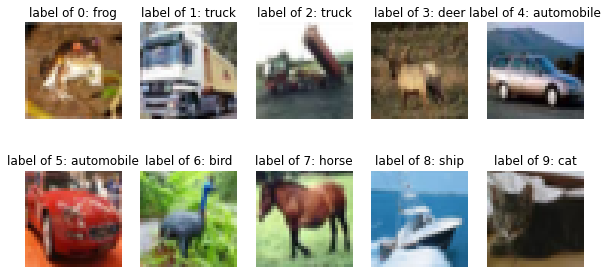

In [9]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'label of {i}: {tolabel(int(train_y[i]))}')
    plt.axis('off')
plt.show()

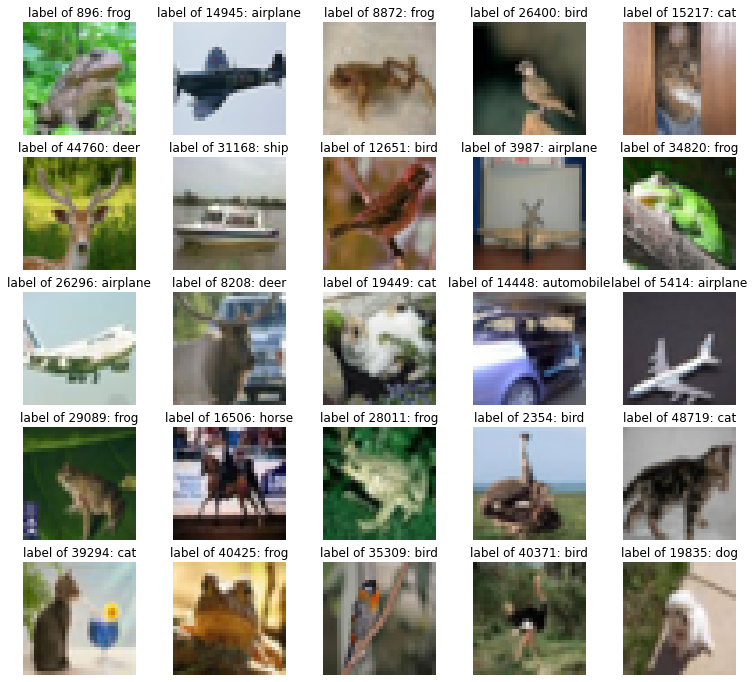

In [10]:
plt.figure(figsize=(13, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'label of {random_index}: {tolabel(int(train_y[random_index]))}')
    plt.axis('off')

plt.show()

### 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
* 왜 -1, 1로 정규화를 해주는 것일까?

cifar10은 0~255의 RGB값을 픽셀값으로 가집니다. 이에 대해 확인합니다.

In [11]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


cifar10은 컬러 이미지이므로, 채널값이 3입니다. train set은 5만장으로 구성되어 있고, 32*32의 이미지 사이즈를 가지고 있습니다.

In [12]:
train_x.shape

(50000, 32, 32, 3)

### tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성
* tensor란 무엇인가?

In [13]:
BUFFER_SIZE = 50000 # 전체 데이터셋을 섞기 위해 60000으로 설정한다. 
BATCH_SIZE = 256
RANDOM_DIM = 100

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP 2. 생성자 모델 구현하기

### (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수

In [15]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # Dense layer to 4*4
    model.add(layers.Dense(4*4*BATCH_SIZE, use_bias=False, input_shape=(RANDOM_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.ReLU())
    # Reshape layer
    model.add(layers.Reshape((4, 4, BATCH_SIZE)))

    # Upsampling: Conv2DTranspose layer to 8*8
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.ReLU())
    
    # Upsampling: Conv2DTranspose layer to 16*16
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.ReLU())

    # Upsampling: Conv2DTranspose layer to 32*32
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.ReLU())
    
    # Output: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', activation='tanh', use_bias=False))

    return model

In [16]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         294912    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

### noise = tf.random.normal([BatchSize, RandomDim])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성

In [17]:
noise = tf.random.normal([1, RANDOM_DIM])

### 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [18]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

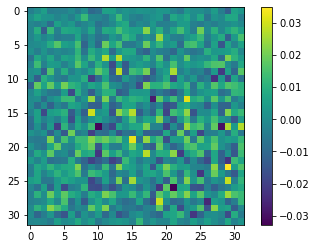

In [19]:
plt.imshow(generated_image[0, :, :, 0]) # batch, width, height, channel 
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

### (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성

In [20]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # downsampling: Conv2D Layer to 32*32
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3], use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # downsampling: Conv2D Layer to 16*16
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # downsampling: Conv2D Layer to 8*8
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
#     # downsampling: Conv2D Layer to 4*4
#     model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
# #     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Dropout(0.25))
    
    # classifier 
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [21]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1728      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73728     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

### STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [22]:
decision = discriminator(generated_image, training=False)
decision.shape

TensorShape([1, 1])

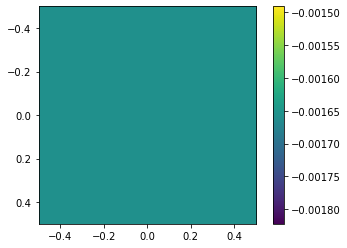

In [23]:
plt.imshow(decision)
plt.colorbar()
plt.show()

## STEP 4. 손실함수와 최적화 함수 구현하기


### 생성자와 판별자의 손실함수(loss)를 구현
판별자 모델의 맨 마지막 Layer에는 값을 정규화시키는 sigmoid나 tanh 함수와 같은 활성화 함수가 없었습니다. 즉, 구분자가 출력하는 값은 범위가 정해지지 않아 모든 실숫값을 가질 수 있었습니다. tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 (참고). **따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.**

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수

In [27]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 생성자와 판별자를 최적화하는 optimizer를 정의

In [28]:
# 앞선 연구들에 의해 실험적으로 알려진 하이퍼 파라미터값 
lr = 2e-4 # learning-rate le-4 > le-3 > le-2
beta1 = 0.5
lr

0.0002

In [29]:
# adapted from keras.optimizers.Adam
class AdamWithWeightnorm(tf.keras.optimizers.Adam):
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations, K.floatx())))

        t = K.cast(self.iterations + 1, K.floatx())
        lr_t = lr * K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t))

        shapes = [K.get_variable_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):

            # if a weight tensor (len > 1) use weight normalized parameterization
            # this is the only part changed w.r.t. keras.optimizers.Adam
            ps = K.get_variable_shape(p)
            if len(ps)>1:

                # get weight normalization parameters
                V, V_norm, V_scaler, g_param, grad_g, grad_V = get_weightnorm_params_and_grads(p, g)

                # Adam containers for the 'g' parameter
                V_scaler_shape = K.get_variable_shape(V_scaler)
                m_g = K.zeros(V_scaler_shape)
                v_g = K.zeros(V_scaler_shape)

                # update g parameters
                m_g_t = (self.beta_1 * m_g) + (1. - self.beta_1) * grad_g
                v_g_t = (self.beta_2 * v_g) + (1. - self.beta_2) * K.square(grad_g)
                new_g_param = g_param - lr_t * m_g_t / (K.sqrt(v_g_t) + self.epsilon)
                self.updates.append(K.update(m_g, m_g_t))
                self.updates.append(K.update(v_g, v_g_t))

                # update V parameters
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * grad_V
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(grad_V)
                new_V_param = V - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)
                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                # if there are constraints we apply them to V, not W
                if getattr(p, 'constraint', None) is not None:
                    new_V_param = p.constraint(new_V_param)

                # wn param updates --> W updates
                add_weightnorm_param_updates(self.updates, new_V_param, new_g_param, p, V_scaler)

            else: # do optimization normally
                m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
                v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
                p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

                self.updates.append(K.update(m, m_t))
                self.updates.append(K.update(v, v_t))

                new_p = p_t
                # apply constraints
                if getattr(p, 'constraint', None) is not None:
                    new_p = p.constraint(new_p)
                self.updates.append(K.update(p, new_p))
        return self.updates

def get_weightnorm_params_and_grads(p, g):
    ps = K.get_variable_shape(p)

    # construct weight scaler: V_scaler = g/||V||
    V_scaler_shape = (ps[-1],)  # assumes we're using tensorflow!
    V_scaler = K.ones(V_scaler_shape)  # init to ones, so effective parameters don't change

    # get V parameters = ||V||/g * W
    norm_axes = [i for i in range(len(ps) - 1)]
    V = p / tf.reshape(V_scaler, [1] * len(norm_axes) + [-1])

    # split V_scaler into ||V|| and g parameters
    V_norm = tf.sqrt(tf.reduce_sum(tf.square(V), norm_axes))
    g_param = V_scaler * V_norm

    # get grad in V,g parameters
    grad_g = tf.reduce_sum(g * V, norm_axes) / V_norm
    grad_V = tf.reshape(V_scaler, [1] * len(norm_axes) + [-1]) * \
             (g - tf.reshape(grad_g / V_norm, [1] * len(norm_axes) + [-1]) * V)

    return V, V_norm, V_scaler, g_param, grad_g, grad_V

def add_weightnorm_param_updates(updates, new_V_param, new_g_param, W, V_scaler):
    ps = K.get_variable_shape(new_V_param)
    norm_axes = [i for i in range(len(ps) - 1)]

    # update W and V_scaler
    new_V_norm = tf.sqrt(tf.reduce_sum(tf.square(new_V_param), norm_axes))
    new_V_scaler = new_g_param / new_V_norm
    new_W = tf.reshape(new_V_scaler, [1] * len(norm_axes) + [-1]) * new_V_param
    updates.append(K.update(W, new_W))
    updates.append(K.update(V_scaler, new_V_scaler))

# data based initialization for a given Keras model
def data_based_init(model, input):
    # input can be dict, numpy array, or list of numpy arrays
    if type(input) is dict:
        feed_dict = input
    elif type(input) is list:
        feed_dict = {tf_inp: np_inp for tf_inp,np_inp in zip(model.inputs,input)}
    else:
        feed_dict = {model.inputs[0]: input}

    # add learning phase if required
    if model.uses_learning_phase and K.learning_phase() not in feed_dict:
        feed_dict.update({K.learning_phase(): 1})

    # get all layer name, output, weight, bias tuples
    layer_output_weight_bias = []
    for l in model.layers:
        trainable_weights = l.trainable_weights
        if len(trainable_weights) == 2:
            W,b = trainable_weights
            assert(l.built)
            layer_output_weight_bias.append((l.name,l.get_output_at(0),W,b)) # if more than one node, only use the first

    # iterate over our list and do data dependent init
    sess = K.get_session()
    for l,o,W,b in layer_output_weight_bias:
        print('Performing data dependent initialization for layer ' + l)
        m,v = tf.nn.moments(o, [i for i in range(len(o.get_shape())-1)])
        s = tf.sqrt(v + 1e-10)
        updates = tf.group(W.assign(W/tf.reshape(s,[1]*(len(W.get_shape())-1)+[-1])), b.assign((b-m)/s))
        sess.run(updates, feed_dict)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1, beta_2=0.999)

# Weight Nomalizer for Optimizer 
# generator_optimizer = AdamWithWeightnorm(lr=lr, beta_1=beta1)
# discriminator_optimizer = AdamWithWeightnorm(lr=lr, beta_1=beta1)

## STEP 5. 훈련과정 상세 기능 구현하기

### 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수
* 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
* 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
* tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
* generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
* discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
* loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
* accuracy 계산 : fake_output, real_output으로 discriminator가
* gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
* 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
*
리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [31]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수

In [32]:
noise_dim = RANDOM_DIM
num_examples_to_generate = 36

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([36, 100])

In [33]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(6, 6))
    for i in range(predictions.shape[0]):
        plt.subplot(6, 6, i+1)
        plt.imshow(((predictions[i].numpy()* 127.5) + 127.5).astype(int))
        plt.axis('off')
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현

In [34]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈

In [35]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기

### 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습

In [36]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [37]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

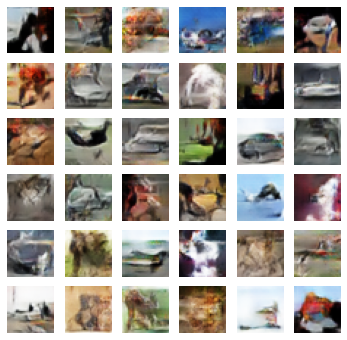

Time for training : 2968 sec


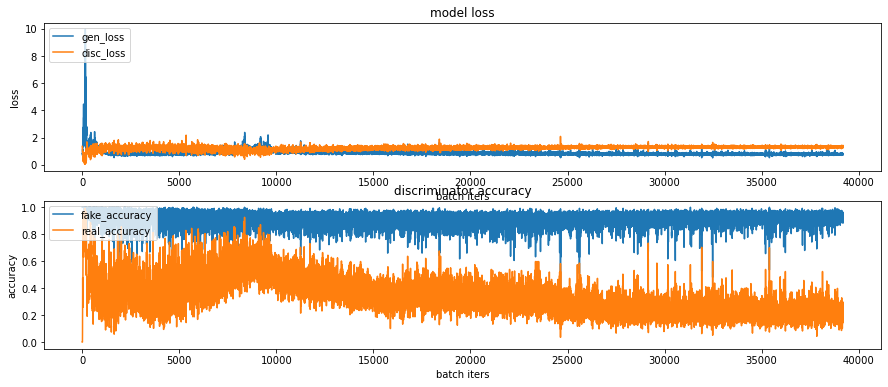

CPU times: user 48min 56s, sys: 1min 41s, total: 50min 38s
Wall time: 49min 30s


In [38]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

### 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현

In [39]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 aiffel-dj19 aiffel-dj19 5342415  3월  2 22:09 /home/aiffel-dj19/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


### 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지

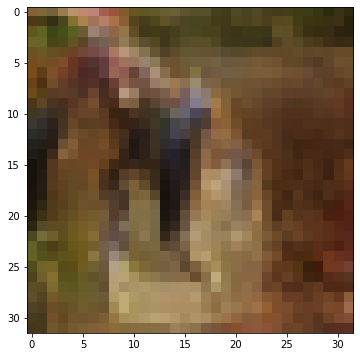

In [40]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, RANDOM_DIM])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## STEP 7. (optional) GAN 훈련 과정 개선하기


### STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석

### 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)

## 회고

### 질문
* 왜 이미지를 -1, 1로 정규화를 해주는 것일까?


[E12-12] 데코레이터. (https://bluese05.tistory.com/30) 중 질문.
Q1. 아래와 같은 코드와 같이 nested function을 선언해야 하는것인가?
def datetime_decorator(func):
def decorated():
print datetime.datetime.now()
func()
print datetime.datetime.now()
return decorated

Q2. 클래스로 데코레이터 생성 시 func의 역할이 헷갈립니다.
class DatetimeDecorator:
def init(self, f):
self.func = f
def call(self, *args, **kwargs):
print datetime.datetime.now()
self.func(*args, **kwargs)
print datetime.datetime.now()

## 루브릭 
* GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
    - 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
* 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
    - gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
* 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
    - 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.


### 루브릭 3번 
* 참고 링크: https://github.com/soumith/ganhacks
* For Downsampling, use: Average Pooling, Conv2d + stride
* For Upsampling, use: PixelShuffle, ConvTranspose2d + stride <br>
    PixelShuffle: https://arxiv.org/abs/1609.05158 <br>
* Use SGD for discriminator and ADAM for generator